# Estimate Paramters of system of ODEs for given time course data

imports

In [1]:
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver
from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting
import matplotlib.pyplot as plt # plot data and results

### Get data from excel

In [2]:
data = './datasets/Stephan_pH7.xlsx'
df = pd.read_excel(data, sheet_name=1)

### Convert dataframe to np-array

In [3]:
# time:
data_time = df[df.columns[0]].to_numpy(np.float64) #shape: (60,)
# substrate data (absorption):
data_s = np.transpose(df.iloc[:,1:].to_numpy(np.float64)) #shape: (3, 60)

## Fit data to system of odes

### define the ode functions

In [4]:
def f(w, t, paras):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,s]
        t: time
        params: parameters
    '''
    v, s = w
    
    try:
        a = paras['a'].value
        vmax = paras['vmax'].value
        km = paras['km'].value

    except KeyError:
        a, vmax, km = paras
    
    
    # f(v',s'):
    f0 = a*(vmax-v) # v'
    f1 = -v*s/(km+s) # s'
    return [f0,f1]

### Solve ODE

In [5]:
def g(t, w0, paras):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [v0, s0])
    '''
    w = odeint(f, w0, t, args=(paras,))
    return w

### compute residual between actual data (s) and fitted data

In [6]:
def res_multi(params, t, data_s):
    ndata, nt = data_s.shape
    resid = 0.0*data_s[:]
    # residual per data set
    for i in range(ndata):
        w0 = params['v0'].value, params['s0'].value
        model = g(t, w0, params)
        # only have data for s not v
        s_model = model[:,1]
        s_model_b = s_model + params['b'].value
        resid[i,:]=data_s[i,:]-s_model_b
    return resid.flatten()

### Bringing everything together
Initialize parameters

In [7]:
# initial conditions:
v0 = 0
s0 = np.mean(data_s,axis=0)[0]

# Set parameters including bounds
bias = 0.1
params = Parameters()
params.add('v0', value=v0, vary=False)
params.add('s0', value=s0-bias, min=0.1, max=s0)
params.add('a', value=1., min=0.0001, max=2.)
params.add('vmax', value=0.2, min=0.0001, max=1.)
params.add('km', value=0.05, min=0.0001, max=1.)
params.add('b', value=bias, min=0.01, max=0.5)

# time
t_measured = data_time

Fit model and visualize results

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 96
    # data points      = 180
    # variables        = 5
    chi-square         = 0.04123983
    reduced chi-square = 2.3566e-04
    Akaike info crit   = -1498.63538
    Bayesian info crit = -1482.67059
[[Variables]]
    v0:    0 (fixed)
    s0:    0.86085398 +/- 0.00534285 (0.62%) (init = 0.8780667)
    a:     1.69791467 +/- 0.15515893 (9.14%) (init = 1)
    vmax:  0.28159258 +/- 0.01082300 (3.84%) (init = 0.2)
    km:    0.04761797 +/- 0.01094650 (22.99%) (init = 0.05)
    b:     0.09725106 +/- 0.00436845 (4.49%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, km) =  0.947
    C(a, vmax)  = -0.895
    C(a, km)    = -0.743
    C(s0, b)    = -0.736
    C(km, b)    = -0.638
    C(vmax, b)  = -0.504
    C(a, b)     =  0.333
    C(s0, km)   =  0.312
    C(s0, a)    =  0.211
    C(s0, vmax) =  0.122


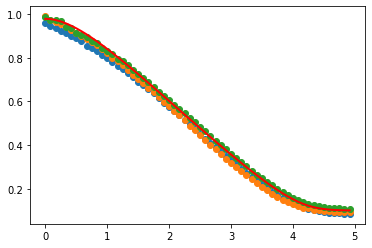

In [8]:
# fit model
result = minimize(res_multi , params, args=(t_measured, data_s), method='leastsq')  # leastsq nelder
report_fit(result)
# plot the data sets and fits
w0 = params['v0'].value, params['s0'].value
data_fitted = g(t_measured, w0, result.params)
plt.figure()

for i in range(data_s.shape[0]):
    plt.plot(t_measured, data_s[i, :], 'o')
plt.plot(t_measured, data_fitted[:, 1]+params['b'].value, '-', linewidth=2, color='red', label='fitted data')
plt.show()